In [48]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from tqdm import tqdm

import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [49]:
from bcnf.models.cnf import CondRealNVP_v2
from bcnf.utils import get_dir
from bcnf.utils import load_config, load_data, sub_root_path
from bcnf.eval.calibration import compute_y_hat_ranks, compute_CDF_residuals

from bcnf.train.trainer_data_handler import TrainerDataHandler
from bcnf.train.utils import get_data_type

## Model

In [50]:
MODEL_NAME = f'videos_double_CNN_LSTM_large'

In [110]:
BALL = "Small_Wasserball"

In [111]:
with open(os.path.join(get_dir('models', 'bcnf-models', MODEL_NAME), 'config.json'), 'r') as f:
    config = load_config(json.load(f)['config_path'])
    # config['data']['path'] = sub_root_path(config['data']['path']).replace('/train', '/test')
    config['data']['path'] = os.path.join(get_dir('data', 'bcnf-data', 'Videos', BALL), f'{BALL}.pkl')

    print(config['data']['path'])

cnf = CondRealNVP_v2.from_config(config).to(device)

cnf.load_state_dict(torch.load(os.path.join(get_dir('models', 'bcnf-models', MODEL_NAME), "state_dict.pt")))

/home/psaegert/Projects/bcnf/data/bcnf-data/Videos/Small_Wasserball/Small_Wasserball.pkl
Example camera input size: torch.Size([1, 1, 90, 160])
Output size after first layer: torch.Size([1, 5, 45, 80])
Output size after layer 1: torch.Size([1, 10, 22, 40])
Output size after layer 2: torch.Size([1, 15, 10, 19])
Final output size: 5700
ModuleList(
  (0): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.25, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(10, 15, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Dropout(p=0.25, inplace=False)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_m

<All keys matched successfully>

In [112]:
print(f'Number of parameters: {cnf.n_params:,}')

Number of parameters: 57,355,414


In [113]:
parameter_selection = cnf.parameter_index_mapping.parameters

## Data

In [114]:
T = 2
dt = 1/15

In [115]:
# data = load_data(sub_root_path(config['data']['path']).replace('/train', '/test'), verbose=True, keep_output_type='trajectories')
# data = load_data(sub_root_path(config['data']['path']).replace('/train', '/test'), verbose=True, keep_output_type='videos')

data = load_data(
    os.path.join(get_dir('data', 'bcnf-data', 'Videos', BALL), f'{BALL}.pkl'),
    verbose=True,
    keep_output_type='videos',
    errors='ignore')

Loading data from file...
Found key "cams" in file "<_io.BufferedReader name='/home/psaegert/Projects/bcnf/data/bcnf-data/Videos/Small_Wasserball/Small_Wasserball.pkl'>". Renaming to "videos".


In [116]:
config_prior = copy.deepcopy(config)
config_prior['data']['path'] = sub_root_path('{{BCNF_ROOT}}/data/bcnf-data/fixed_data_render_2s_15FPS/train')

y_train, _ = TrainerDataHandler().get_data_for_training(
    config_prior,
    cnf.parameter_index_mapping,
    dtype=get_data_type(dtype=config["global"]["dtype"]),
    errors='ignore',
    verbose=True,
    return_tensor_dataset=False)

print(f'{y_train.shape=}')

Loading data from /home/psaegert/Projects/bcnf/data/bcnf-data/fixed_data_render_2s_15FPS/train...


Loading data from directory: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it, file=fixed_data_render_2s_15FPS_1.pkl]

Found key "traj" in file "fixed_data_render_2s_15FPS_1.pkl". Renaming to "trajectories".
Found key "cams" in file "fixed_data_render_2s_15FPS_1.pkl". Renaming to "videos".


Using videos data for training. Shapes:
Conditions: [torch.Size([1000, 2, 30, 90, 160]), torch.Size([1000, 7])]
Parameters: torch.Size([1000, 19])
y_train.shape=torch.Size([1000, 19])


In [117]:
y, conditions = TrainerDataHandler().get_data_for_training(
    config,
    cnf.parameter_index_mapping,
    dtype=get_data_type(dtype=config["global"]["dtype"]),
    errors='ignore',
    verbose=True,
    return_tensor_dataset=False)

print(f'{y.shape=}')
for condition in conditions:
    print(f'{condition.shape=}')

Loading data from /home/psaegert/Projects/bcnf/data/bcnf-data/Videos/Small_Wasserball/Small_Wasserball.pkl...
Loading data from file...
Found key "cams" in file "<_io.BufferedReader name='/home/psaegert/Projects/bcnf/data/bcnf-data/Videos/Small_Wasserball/Small_Wasserball.pkl'>". Renaming to "videos".
Using videos data for training. Shapes:
Conditions: [torch.Size([1, 2, 30, 90, 160]), torch.Size([1, 7])]
Parameters: torch.Size([1, 19])
y.shape=torch.Size([1, 19])
condition.shape=torch.Size([1, 2, 30, 90, 160])
condition.shape=torch.Size([1, 7])


## Code Space

In [118]:
# z = torch.empty(y.shape)
# batch_size = 32

# with torch.no_grad():
#     for i in tqdm(range(0, len(y), batch_size)):
#         z[i:i+batch_size] = cnf.forward(y[i:i+batch_size].to(device), *[c[i:i+batch_size].to(device) for c in conditions])

In [119]:
# COLS = 6
# ROWS = np.ceil(z.shape[1] / COLS).astype(int)

# fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3, ROWS * 3))

# for i in range(z.shape[1]):
#     axes.flatten()[i].hist(z[:, i], alpha=0.5, color='C0', label='Code Distribution', bins=np.linspace(-3, 3, 32), density=True)
#     axes.flatten()[i].set_title(f'z_{i}')

#     # Plot the standard normal distribution
#     x = np.linspace(-3, 3, 100)
#     axes.flatten()[i].plot(x, np.exp(-x**2/2) / np.sqrt(2 * np.pi), label=r'$\mathcal{N}\,(0, 1)$', color='C0')

# for i in range(z.shape[1], COLS * ROWS):
#     axes.flatten()[i].axis('off')

# axes[0, 0].legend()

# fig.tight_layout();

## Calibration

In [120]:
M_SAMPLES = 10_000
example_id = 0

In [121]:
y_hat = cnf.sample(
    M_SAMPLES,
    *[c[example_id:example_id+1].to(device) for c in conditions],
    batch_size=16,
    outer=True,
    verbose=True)
y_hat = y_hat.cpu().detach().numpy()
y_hat.shape

Batch Sampling: 100%|██████████| 1/1 [00:10<00:00, 10.28s/it]


(10000, 1, 19)

In [122]:
y_prior = y_train.to('cpu').detach().numpy()
y_prior.shape

(1000, 19)

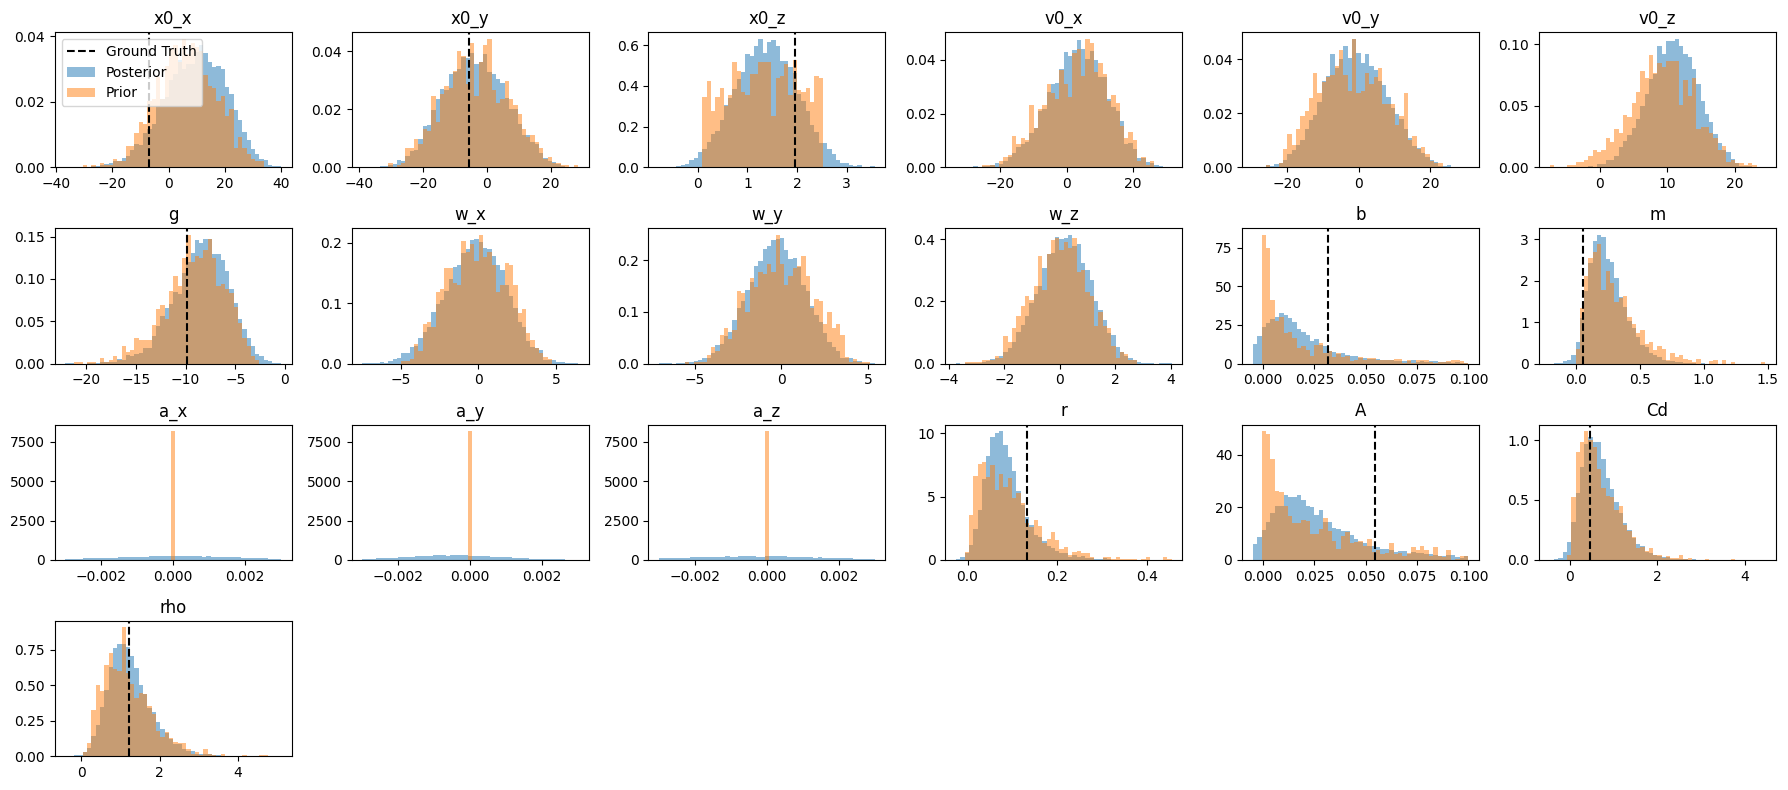

In [123]:
COLS = 6
ROWS = np.ceil(y_hat.shape[2] / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3, ROWS * 2))

for i, name in zip(range(y_hat.shape[2]), cnf.parameter_index_mapping.parameters):
    vmin = np.min(np.concatenate([y_hat[:, 0, i].flatten(), y_prior[:, i].flatten()]))
    vmax = np.max(np.concatenate([y_hat[:, 0, i].flatten(), y_prior[:, i].flatten()]))

    if np.isnan(vmin) or np.isnan(vmax):
        continue

    if name in ['b', 'A']:
        bins = np.linspace(-0.005, 0.1, 50)
        range_ = (-0.05, 0.25)
    elif name.startswith('a_'):
        bins = np.linspace(-0.003, 0.003, 50)
        range_ = (-0.003, 0.003)
    else:
        bins = 50
        range_ = (vmin, vmax)

    axes.flatten()[i].axvline(y[example_id, i].cpu().detach().numpy(), color='k', linestyle='--', label='Ground Truth')
    axes.flatten()[i].hist(y_hat[:, 0, i].flatten(), alpha=0.5, color='C0', label='Posterior', bins=bins, range=range_, density=True)
    axes.flatten()[i].set_title(name)

    # Show the prior
    axes.flatten()[i].hist(y_prior[:, i], alpha=0.5, color='C1', label='Prior', bins=bins, range=range_, density=True)

for i in range(y_hat.shape[2], COLS * ROWS):
    axes.flatten()[i].axis('off')

axes[0, 0].legend()

fig.tight_layout();

plt.savefig(os.path.join(get_dir('results', f'{MODEL_NAME}', 'irl', 'figures', create=True), f'posterior_samples_{BALL}.png'))